In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


In [2]:
df = pd.read_csv('train_data.csv',index_col=0)
df.shape

(56389, 29)

## Data Preparation 

In [3]:
def preparation(df):
#Drop unused columns 
    df = df.drop([ 'bed_type', 'first_review', 'host_has_profile_pic','latitude','longitude','name',
                  'neighbourhood','thumbnail_url','zipcode'], axis = 1)

    # create dummies for 'property_type'
    df['is_apt'] = df['property_type'].apply(lambda x: 1 if x=='Apartment' else 0)
    df['is_house'] = df['property_type'].apply(lambda x: 1 if x=='House' else 0)
    df['is_other_ppt_type'] = df['property_type'].apply(lambda x: 1 if (x!='Apartment') | (x!='House') else 0)

    # Create dummies for 'room_type'
    df['is_entireRoom'] = df['room_type'].apply(lambda x: 1 if x=='Entire home/apt' else 0)
    df['is_privateRoom'] = df['room_type'].apply(lambda x: 1 if x=='Private room' else 0)
    df['is_sharedRoom'] = df['room_type'].apply(lambda x: 1 if x=='Shared room' else 0)

    # Ordinal variables
    df['is_cancellation_policy'] = df['cancellation_policy'].apply(lambda x: 1 if (x =='strict') |(x =='super_strict_30')|(x =='super_strict_60') 
                                                                else (2 if x=='moderate' else 3))

    # Binary variables
    df['is_cleaning_fee'] = df['cleaning_fee'].apply(lambda x: 1 if x is True else 0)
    df['is_instantBookable'] = df['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)
    df['is_instantBookable'] = df['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)
    df.host_identity_verified = df.host_identity_verified.apply(lambda x: 1 if x=='t' else 0)


    # Change 'city' to categorical 
    df['is_city_nyc'] = df['city'].apply(lambda x: 1 if x=='NYC' else 0)
    df['is_city_la'] = df['city'].apply(lambda x: 1 if x=='LA' else 0)
    df['is_city_sf'] = df['city'].apply(lambda x: 1 if x=='SF' else 0)
    df['is_city_dc'] = df['city'].apply(lambda x: 1 if x=='SF' else 0)
    df['is_city_chicago'] = df['city'].apply(lambda x: 1 if x=='Chicago' else 0)


    df.drop(columns = ['property_type', 'room_type', 'cancellation_policy', 'cleaning_fee', 'instant_bookable', 'instant_bookable', 'city', 'last_review'], axis = 1, inplace = True)
    
    return df

In [4]:
df = preparation(df)

### Missing Value

In [5]:
def fill_na(df):
    df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype('float') / 100.0
    df['host_response_rate'] = df['host_response_rate'].interpolate().round(2)


    # df.bathrooms = df.bathrooms.fillna(df.bathrooms.median())
    df['beds'] = df['beds'].interpolate().round(2).astype('int32')
    df['bedrooms'] = df['bedrooms'].interpolate().round(2).astype('int32')
    df['bathrooms'] = df['bathrooms'].interpolate().round(2).astype('int32')

    df.host_response_rate = df.host_response_rate.fillna(0)
    
    return df

In [6]:
df = fill_na(df)

### Feature Engineering

In [7]:
# Create 'host_days'
df['host_since']=pd.to_datetime(df['host_since'], format = "%Y-%m-%d")
today = datetime.datetime.today()
host_days = today-df['host_since']
df['host_days'] = host_days.dt.days
df['host_days'] = df['host_days'].interpolate().round(2).astype('int32')

# Calculate number of beds per bedroom
df.loc[df['bedrooms']==0,'bedrooms'] = 1
df['bath_per_bedrooms'] = df.bathrooms/df.bedrooms          
df['beds_per_person']=df.beds/df.accommodates

df.drop(columns = ['bathrooms','bedrooms','beds','accommodates','host_since'], axis = 1, inplace = True)

In [8]:
# convert to uint for saving storage
df.is_instantBookable = df.is_instantBookable.astype('uint8')

df.host_identity_verified = df.host_identity_verified.astype('uint8')

df.is_apt = df.is_apt.astype('uint8')

df.is_house = df.is_house.astype('uint8')

df.is_other_ppt_type = df.is_other_ppt_type.astype('uint8')

df.is_entireRoom = df.is_entireRoom.astype('uint8')

df.is_privateRoom = df.is_privateRoom.astype('uint8')

df.is_sharedRoom = df.is_sharedRoom.astype('uint8')

df.is_cleaning_fee = df.is_cleaning_fee.astype('uint8')

## Text Data Engineering

#### Amenities

In [11]:
from mlxtend.preprocessing import TransactionEncoder

pd.set_option('display.max_columns', None)

amenities = df.amenities

import regex as re
lt, lst=[],[]
for items in amenities:
    items = items.split(',')
    for item in items:
        item = re.sub(r'["{}]', '', item)
        item = item.strip()
        if item != '':
            lt.append(item)
    lst.append(lt)
    lt=[]
    
te = TransactionEncoder()
te_ary = te.fit(lst).transform(lst)
te_ary.astype("int")

amnt_df=pd.DataFrame(te_ary, columns=te.columns_)
amnt_df = amnt_df.astype(int)

In [12]:
for i in amnt_df.columns:
  if i in ['Children’s books and toys', 'Pack ’n Play/travel crib','Family/kid friendly']:
    amnt_df = amnt_df.rename(columns= {i: 'baby_friendly'})
  elif i in ['Garden or backyard','Patio or balcony']:
    amnt_df = amnt_df.rename(columns= {i: 'garden_patio'})
  elif i in ['Coffee maker','Oven','Microwave','Stove','Refrigerator','Dryer','Washer','Iron','Hair dryer']:
    amnt_df = amnt_df.rename(columns= {i: 'household_appliances'})
  elif i in ['Doorman','Lockbox','Private entrance','Safety card','Self Check-In','Lock on bedroom door','Buzzer/wireless intercom','24-hour check-in','First aid kit','Fire extinguisher']:
    amnt_df = amnt_df.rename(columns= {i: 'good_security_system'})
  elif i in ['Extra pillows and blankets','Bed linens']:
    amnt_df = amnt_df.rename(columns= {i: 'bedroom_essentials'})
  elif i in ['Wheelchair accessible']:
    amnt_df = amnt_df.rename(columns= {i: 'Wheelchair_accessible'})
  elif i in ['Keypad','Laptop friendly workspace','Internet']:
    amnt_df = amnt_df.rename(columns= {i: 'good_working_environment'})
  elif i in ['Dishwasher','Cooking basics','Hot water','Dishes and silverware']:
    amnt_df = amnt_df.rename(columns= {i: 'kitchen_essentials'})
  elif i in ['Cat(s)','Dog(s)','Pets allowed','Pets live on this property']:
    amnt_df = amnt_df.rename(columns= {i: 'pets_allowed'})
  elif i in ['Pool','Gym']:
    amnt_df = amnt_df.rename(columns= {i: 'gym_pool'})
  elif i in ['Elevator in building','Elevator']:
    amnt_df = amnt_df.rename(columns= {i: 'elevator'})
  elif i in ['Bathtub','Hot tub', 'Shampoo']:
    amnt_df = amnt_df.rename(columns= {i: 'bathroom_essentials'})
  elif i in ['Breakfast']:
    amnt_df = amnt_df.rename(columns= {i: 'breakfast'})
  elif i in ['Indoor fireplace']:
    amnt_df = amnt_df.rename(columns= {i: 'fireplace'})
  elif i in['Free parking on premises']:
    amnt_df = amnt_df.rename(columns= {i: 'free_parking'})
  elif i in ['Hangers']:
    amnt_df = amnt_df.rename(columns= {i: 'hangers'})
  elif i in ['Air conditioning']:
    amnt_df = amnt_df.rename(columns= {i: 'air_conditioning'})

    
amnt_df = amnt_df.groupby(level=0, axis=1).sum()
amnt_df = pd.DataFrame(np.where(amnt_df>=1, 1, 0), columns=amnt_df.columns)
amnt_df = amnt_df[['baby_friendly','garden_patio','household_appliances','good_security_system',
                   'bedroom_essentials','Wheelchair_accessible','good_working_environment','kitchen_essentials',
                   'pets_allowed','gym_pool','elevator','bathroom_essentials','breakfast','fireplace',
                   'free_parking','hangers','air_conditioning']]

In [13]:
df.reset_index(inplace = True, drop=True)
df = pd.concat([df, amnt_df], axis=1)
df = df.drop(['id', 'amenities'],axis=1)

,id,log_price,amenities,description,host_identity_verified,host_response_rate,number_of_reviews,review_scores_rating,is_apt,is_house,is_other_ppt_type,is_entireRoom,is_privateRoom,is_sharedRoom,is_cancellation_policy,is_cleaning_fee,is_instantBookable,is_city_nyc,is_city_la,is_city_sf,is_city_dc,is_city_chicago,host_days,bath_per_bedrooms,beds_per_person,baby_friendly,garden_patio,household_appliances,good_security_system,bedroom_essentials,Wheelchair_accessible,good_working_environment,kitchen_essentials,pets_allowed,gym_pool,elevator,bathroom_essentials,breakfast,fireplace,free_parking,hangers,air_conditioning
0,6901257,5.010635,"{""Wireless Internet"",""Air conditioning"",Kitche...","Beautiful, sunlit brownstone 1-bedroom in the ...",1,0.0,2,100.0,1,0,1,1,0,0,1,1,0,1,0,0,0,0,3278,1.000000,0.333333,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,6304928,5.129899,"{""Wireless Internet"",""Air conditioning"",Kitche...",Enjoy travelling during your stay in Manhattan...,0,1.0,6,93.0,1,0,1,1,0,0,1,1,1,1,0,0,0,0,1367,0.333333,0.428571,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,1
2,7919400,4.976734,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",The Oasis comes complete with a full backyard ...,1,1.0,10,92.0,1,0,1,1,0,0,2,1,1,1,0,0,0,0,1604,1.000000,0.600000,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,1
3,3808709,4.744932,"{TV,Internet,""Wireless Internet"",""Air conditio...","Cool, cozy, and comfortable studio located in ...",1,1.0,4,40.0,1,0,1,1,0,0,2,1,1,0,0,0,0,0,2208,1.000000,0.500000,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1
4,12422935,4.442651,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",Beautiful private room overlooking scenic view...,1,1.0,3,100.0,1,0,1,0,1,0,1,1,1,0,0,1,1,0,1379,1.000000,0.500000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0


In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Transform Topic Groups to binary 0 and 1
topics= pd.DataFrame(pd.get_dummies(topic.Group, prefix='topic'))
df = pd.concat([ data,topics], axis=1)

In [3]:
#df = pd.read_csv('models.csv',index_col=0)
df.head(5)

,log_price,host_identity_verified,host_response_rate,number_of_reviews,review_scores_rating,is_apt,is_house,is_other_ppt_type,is_entireRoom,is_privateRoom,...,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13
0,5.010635,1,0.0,2,100.0,1,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0
1,5.129899,0,1.0,6,93.0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4.976734,1,1.0,10,92.0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,4.744932,1,1.0,4,40.0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,4.442651,1,1.0,3,100.0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0


## Model Engineering

### Set Baseline Model 

In [4]:
X, y = df.drop(['log_price'],axis=1),df['log_price']

In [4]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sklearn.model_selection as cv

(x_train, x_test, y_train, y_test) = cv.train_test_split(X, y, test_size=.20)

# Instantiate linear regression model
reg = LinearRegression()

# Fit reg to the training set
reg.fit(x_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = reg.predict(x_test)

# Evaluate the training set r2 of reg
reg_r2 = r2_score(y_test,y_pred)

# Print r2 of reg
print('Model R2 Score: {:.3f}'.format(reg_r2))

Model R2 Score: 0.516


### Random Forest Model with Hyper Parameter Tuning


In [5]:
# Basic imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# Exhaustive Grid Search
from sklearn.model_selection import GridSearchCV

# Set seed for reproducibility
SEED = 2

# Split dataset into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=SEED)

# Initiate rf
forest = RandomForestRegressor(random_state = SEED)

# Set Parameter Grid
n_estimators = [100,200,500,1000]
max_depth = [5, 10, 15,20]
max_features = [5, 8, 12,15]
hyperF = dict(n_estimators = n_estimators, 
              max_depth = max_depth, 
             max_features = max_features)

# Initiate Grid Search
gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1, scoring = "r2")
bestF = gridF.fit(X_train, y_train)



Fitting 3 folds for each of 64 candidates, totalling 192 fits


In [6]:
# Print result sorted by r2.
res = pd.concat([pd.DataFrame(gridF.cv_results_["params"]),
                 pd.DataFrame(gridF.cv_results_["mean_test_score"], columns=["r2"])],axis=1).sort_values("r2", ascending=False)
res

,max_depth,max_features,n_estimators,r2
63,20,15,1000,0.611842
59,20,12,1000,0.611714
62,20,15,500,0.611492
58,20,12,500,0.611414
61,20,15,200,0.610571
...,...,...,...,...
4,5,8,100,0.507250
0,5,5,100,0.472300
2,5,5,500,0.470535
3,5,5,1000,0.469994


In [7]:
# Print best param setting
bestF.best_estimator_

RandomForestRegressor(max_depth=20, max_features=15, n_estimators=1000,
                      random_state=2)

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# Set seed for reproducibility
SEED = 2

# Split dataset into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=SEED)

# Instantiate the forest with best param setttings
rf = RandomForestRegressor(n_estimators=1000,max_depth=20,max_features=15,random_state=SEED)

# Fit 'rf' to the training set
rf.fit(X_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)

# Evaluate the training set r2 of rf
rf_r2 = r2_score(y_test,y_pred)

# Print r2 of rf
print('Model R2 Score: {:.3f}'.format(rf_r2))

Model R2 Score: 0.620


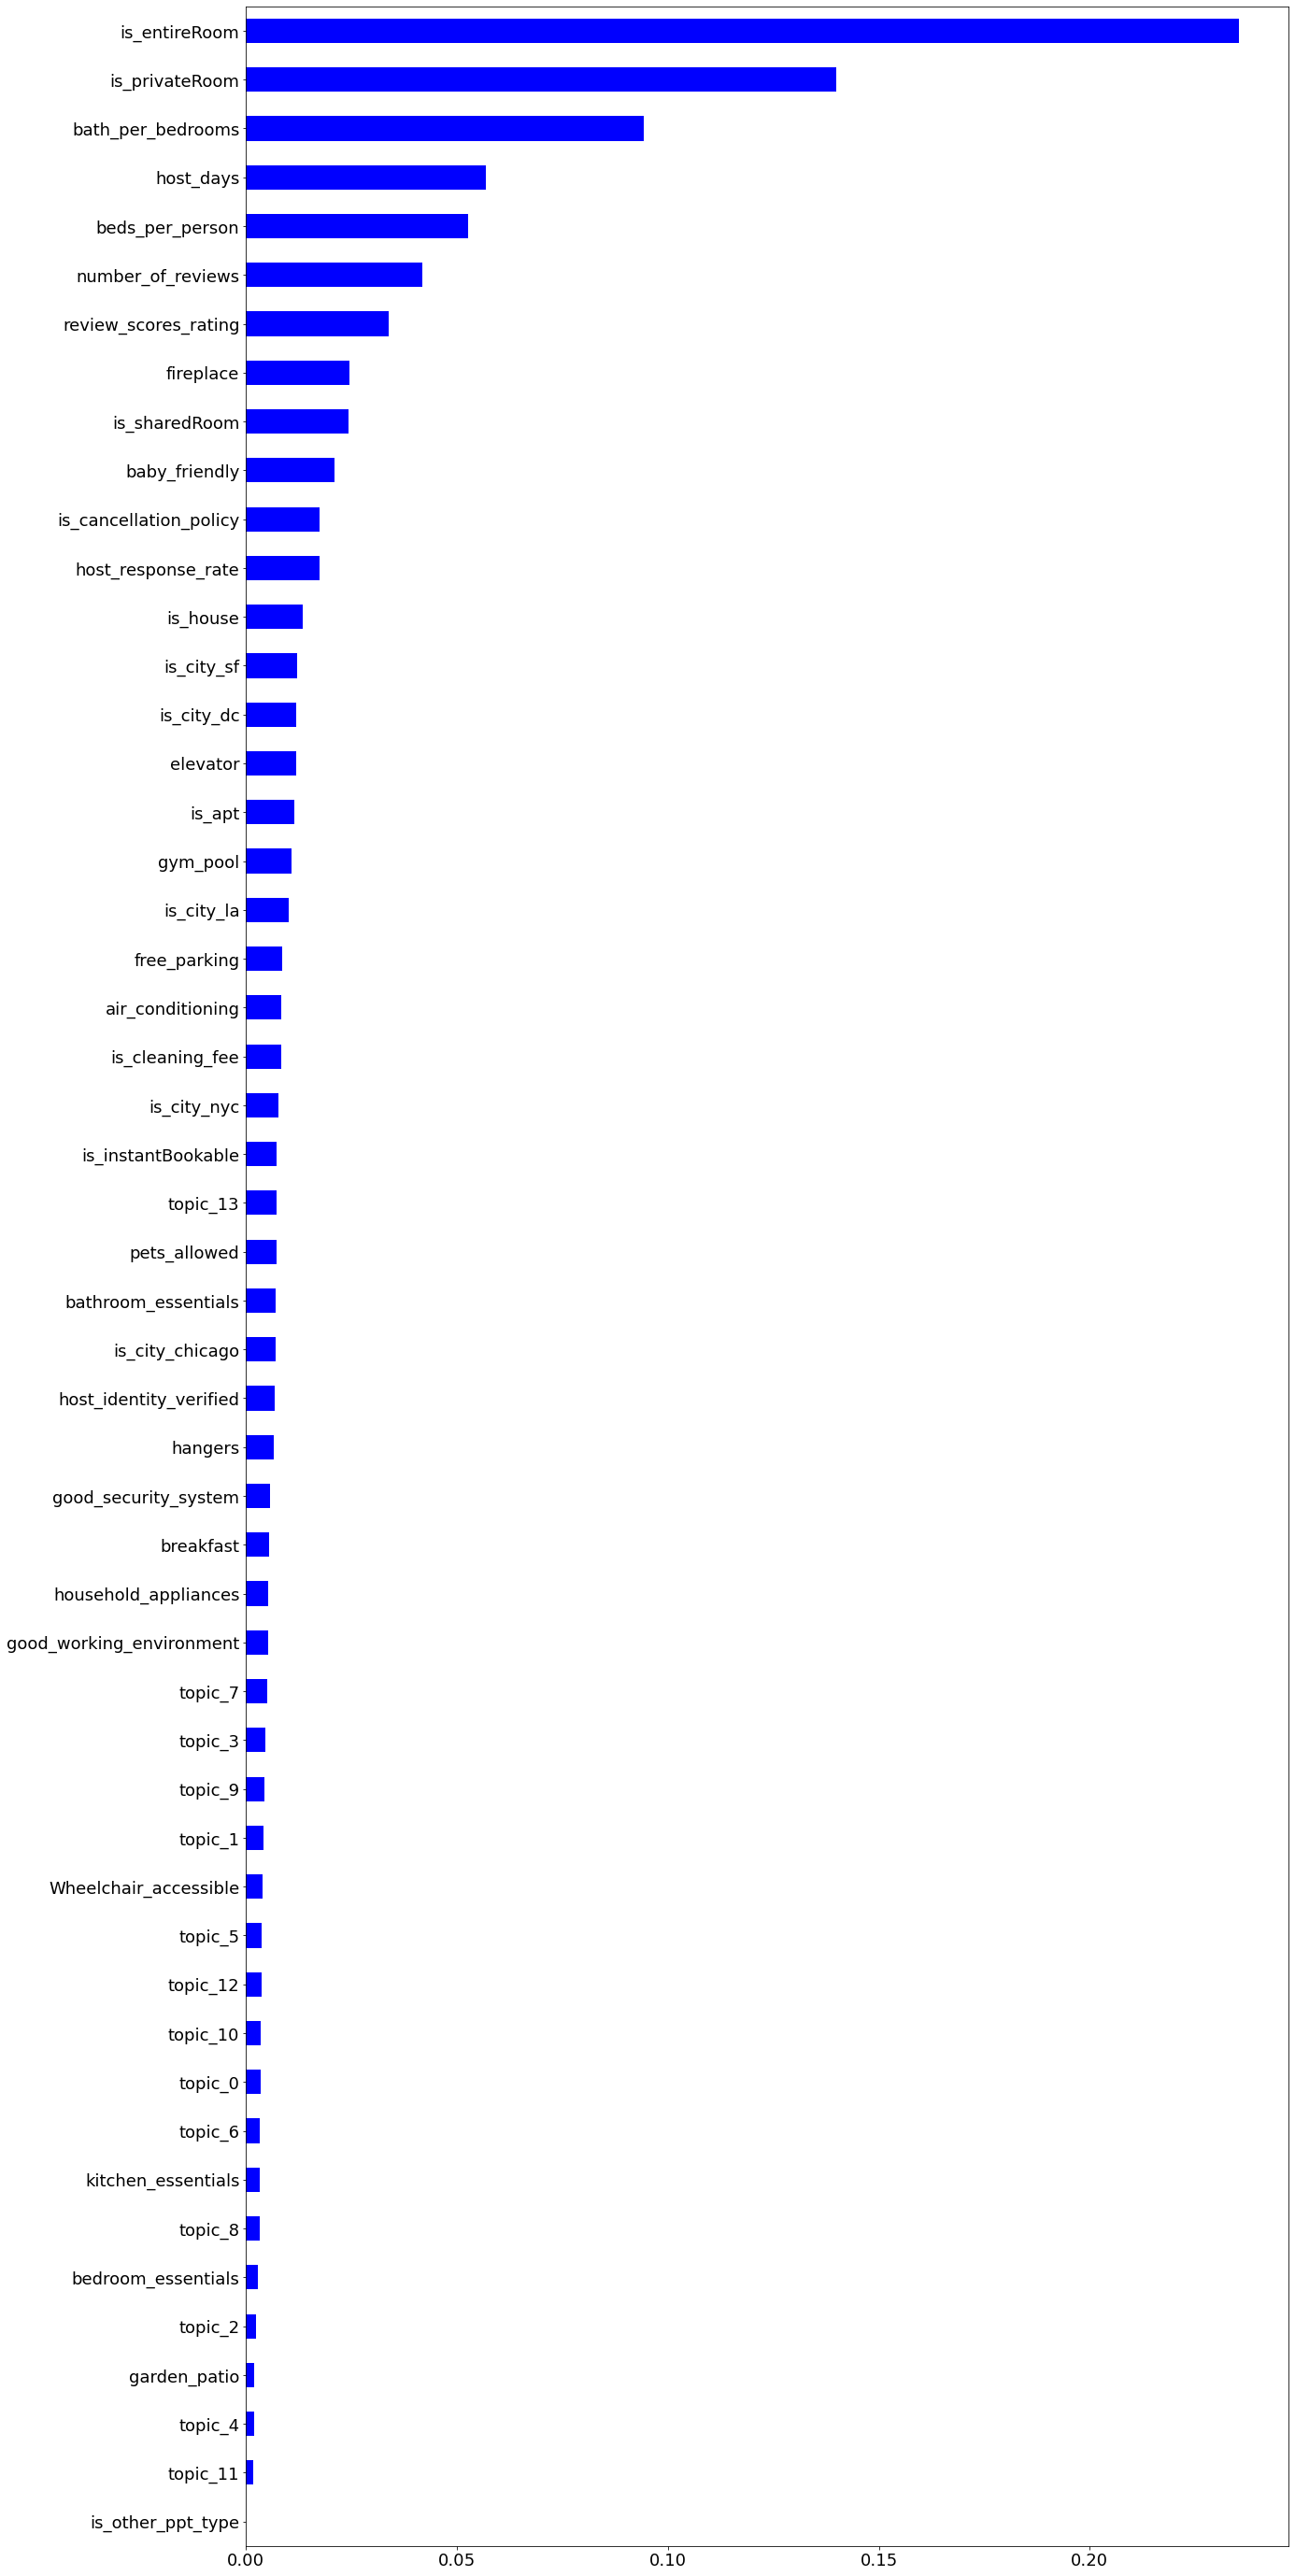

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(20,50))
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_,
index = X.columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='blue',fontsize=18)
plt.show()

The model has better score comparing with simple linear regression. We then calculate the models RMSE and CV RMSE to check for overffiting and underfitting problems. 

In [10]:
from sklearn.metrics import mean_squared_error as MSE

# Compute mse_rf
mse_rf = MSE(y_test, y_pred)
# Compute rmse_rf
rmse_rf= mse_rf**(1/2)

# Predict the labels of the training set
y_pred_train = rf.predict(X_train)
# Evaluate the training set RMSE of rf
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)


# Print rmse
print("Test set RMSE of gb: {:.3f}".format(rmse_rf))
print('Train RMSE: {:.3f}'.format(RMSE_train))


Test set RMSE of gb: 0.415
Train RMSE: 0.240


In [11]:
from sklearn.model_selection import cross_val_score
# Compute the array containing the 10-folds CV MSEs

MSE_CV_scores = - cross_val_score(rf, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

CV RMSE: 0.41


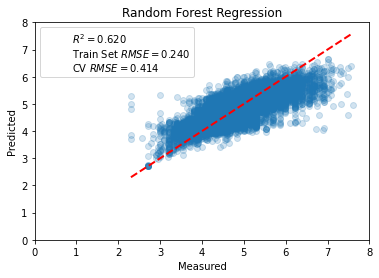

In [12]:
# Plot the predicted and actual y from rf
plt.plot(figsize=(9, 7))
ax =plt.axis([0,8,0,8])

plt.plot([y_test.min(), y_test.max()],
            [y_test.min(), y_test.max()],
            '--r', linewidth=2)
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                           edgecolor='none', linewidth=0)
scores=(r'$R^2= {:.3f}$'+'\n'+'Train Set $RMSE = {:.3f}$'+
        '\n'+'CV $RMSE = {:.3f}$' ).format(rf_r2,RMSE_train,RMSE_CV)

plt.legend([extra],[scores], loc='upper left')
# title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
plt.title('Random Forest Regression')

plt.show()

The results indicates that we don't have a major issue with overfitting and underfitting since our RMSE scores are pretty close. 

Next, we move on to try gradient boosting regressor.

### Gradient Boosting

In [13]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Exhaustive Grid Search
from sklearn.model_selection import GridSearchCV

gradient = GradientBoostingRegressor(random_state = SEED)
n_estimators = [100,200,500,1000]
max_depth = [5, 10, 15,20]
max_features = [5, 8, 12,15]

hyperF = dict(n_estimators = n_estimators, 
              max_depth = max_depth,  
             max_features = max_features)

gridF = GridSearchCV(gradient, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1, scoring = "r2")
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


In [14]:
res = pd.concat([pd.DataFrame(gridF.cv_results_["params"]),
                 pd.DataFrame(gridF.cv_results_["mean_test_score"], columns=["r2"])],axis=1).sort_values("r2", ascending=False)
res

,max_depth,max_features,n_estimators,r2
10,5,12,500,0.617385
14,5,15,500,0.616663
6,5,8,500,0.616233
11,5,12,1000,0.614642
15,5,15,1000,0.614308
...,...,...,...,...
51,20,5,1000,0.588616
60,20,15,100,0.586925
61,20,15,200,0.586829
62,20,15,500,0.586828


In [15]:
bestF.best_estimator_

GradientBoostingRegressor(max_depth=5, max_features=12, n_estimators=500,
                          random_state=2)

In [16]:
# Instantiate gb
gb = GradientBoostingRegressor(max_depth=5, max_features=12, n_estimators=500,random_state=2)

# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = gb.predict(X_test)

# Evaluate the training set r2 of gb
gb_r2 = r2_score(y_test,y_pred)

# Print r2 of gb
print('Model R2 Score: {:.3f}'.format(gb_r2))

Model R2 Score: 0.626


In [17]:
from sklearn.metrics import mean_squared_error as MSE

# Compute mse_gb
mse_gb = MSE(y_test, y_pred)
# Compute rmse_gb
rmse_gb= mse_gb**(1/2)

# Predict the labels of the training set
y_pred_train = gb.predict(X_train)
# Evaluate the training set RMSE of gb
RMSE_train = (MSE(y_train, y_pred_train))**(1/2)


# Print rmse
print("Test set RMSE of gb: {:.3f}".format(rmse_gb))
print('Train RMSE: {:.3f}'.format(RMSE_train))


Test set RMSE of gb: 0.412
Train RMSE: 0.367


In [18]:
from sklearn.model_selection import cross_val_score
# Compute the array containing the 10-folds CV MSEs

MSE_CV_scores = - cross_val_score(gb, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))

CV RMSE: 0.41


### Stacking Regressor Model Comparison Visualization

In [19]:
# Necessary imports 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=2)

reg = LinearRegression()
rf = RandomForestRegressor(n_estimators=1000,max_depth=20,max_features=15,random_state=2)
gb = GradientBoostingRegressor(max_depth=5, max_features=12, n_estimators=500,random_state=2)

estimators = [('Linear Regression', reg), 
              ('Random Forest', rf),
              ('Gradient Boosting',gb)]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       cv=10)

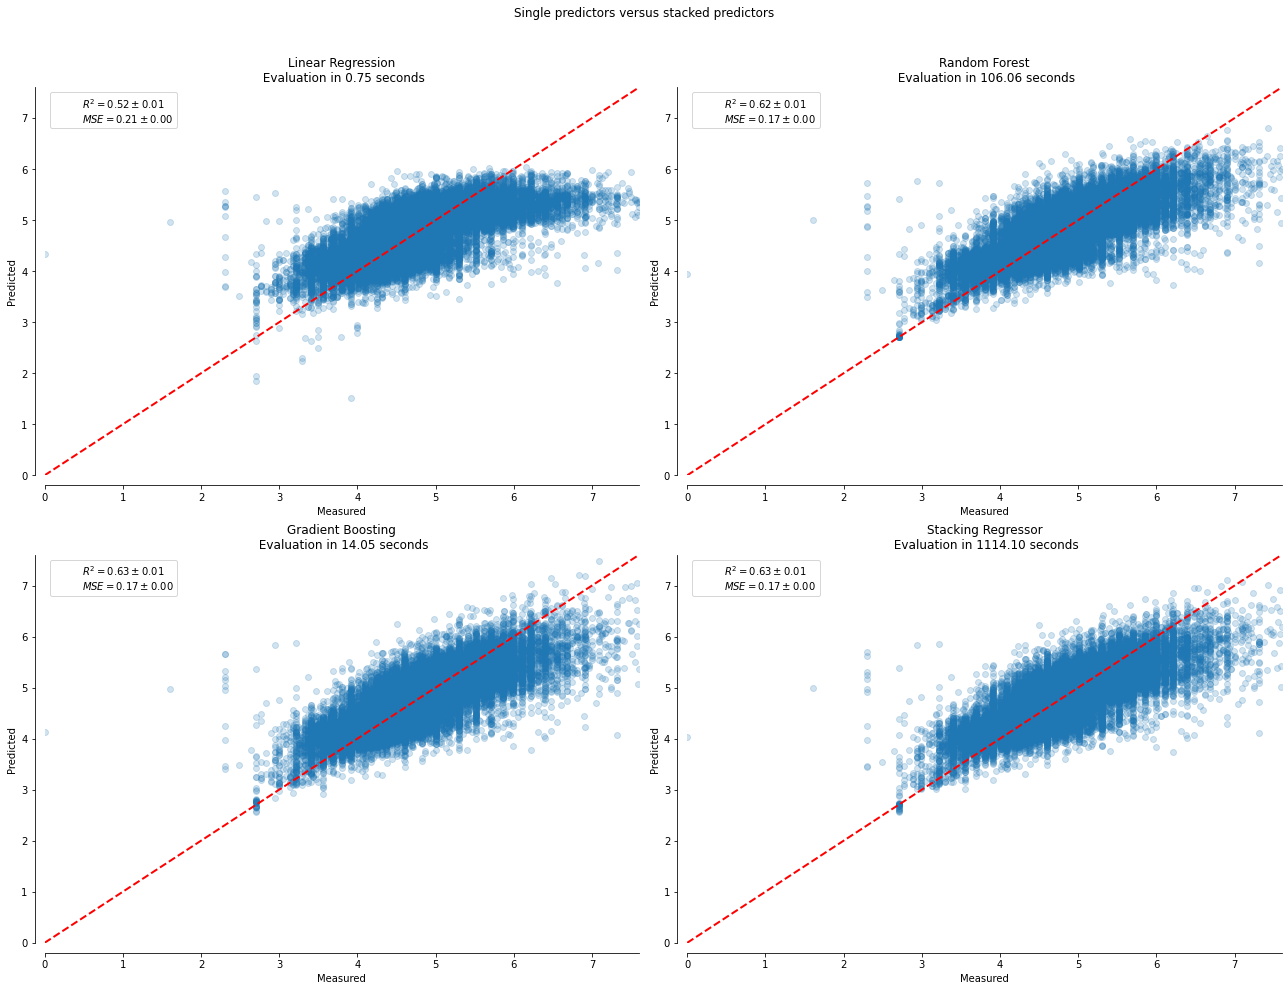

In [20]:
# Print the result from all four models.
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(18, 14))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_squared_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X_train, y_train, n_jobs=-1, verbose=0)

    plot_regression_results(
        ax, y_train, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MSE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_squared_error']),
                np.std(score['test_neg_mean_squared_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Model Interpretation

We use treeinterpreter to decompose the prediction from random forest regressors. 

In [9]:
# Import treeinterpreter
from treeinterpreter import treeinterpreter as ti
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=2)

# Fit the rf regressor
rf = RandomForestRegressor(n_estimators=1000,max_depth=20,max_features=15,random_state=2)
rf.fit(X_train, y_train)

# Sample 2 intances from the train set 
instances = X.iloc[2:4,:]

# Read the result
prediction, bias, contributions = ti.predict(rf,instances)



In [6]:
instances 

,host_identity_verified,host_response_rate,number_of_reviews,review_scores_rating,is_apt,is_house,is_other_ppt_type,is_entireRoom,is_privateRoom,is_sharedRoom,...,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13
2,1,1.0,10,92.0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1.0,4,40.0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
# Print the result from the instances:
for i in range(len(instances)):
    print("Instance", i)
    print("Bias (train set mean)", bias[i])
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], 
                                 X.columns), 
                             key=lambda x: -abs(x[0])):
        print( feature, round(c, 2))
    print( "-"*20 )

Instance 0
Bias (train set mean) 4.747777519144981
Feature contributions:
is_entireRoom 0.19
is_privateRoom 0.13
bath_per_bedrooms -0.1
beds_per_person 0.05
is_cancellation_policy -0.05
is_city_nyc 0.05
baby_friendly 0.04
elevator -0.04
fireplace -0.03
is_city_la 0.03
air_conditioning 0.02
gym_pool -0.02
is_apt -0.01
free_parking 0.01
is_city_sf -0.01
review_scores_rating -0.01
is_city_dc -0.01
is_house -0.01
is_sharedRoom 0.01
is_cleaning_fee 0.01
number_of_reviews 0.01
topic_0 -0.01
bathroom_essentials 0.01
topic_9 0.01
is_city_chicago 0.01
household_appliances 0.01
topic_2 -0.0
host_response_rate 0.0
topic_10 -0.0
host_identity_verified -0.0
topic_7 0.0
breakfast -0.0
pets_allowed 0.0
topic_6 0.0
topic_3 -0.0
topic_12 -0.0
Wheelchair_accessible -0.0
is_instantBookable -0.0
garden_patio -0.0
topic_4 0.0
host_days -0.0
topic_5 -0.0
topic_13 -0.0
good_working_environment -0.0
topic_11 -0.0
hangers 0.0
kitchen_essentials -0.0
good_security_system 0.0
bedroom_essentials -0.0
topic_8 0.0
